# Focality Branch
- find a way of simulating focal vs non-focal tasks

In [343]:
from glob import glob as glob
import torch as tr
import numpy as np

from PMmodel import *

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### notes
- min trainable nback: stsize10,edim5,seqlen15,trepochs10k,thresh95,evalacc90


# saved data

In [344]:
def load_score(fpath,verb=False):
  neps = 1500
  teseqlen = 15
  fpathL = glob('model_data/'+fpath)
  if verb:
    for i in fpathL: print(i)
  nnets = len(fpathL)
  score = -np.ones([nnets,neps,teseqlen])
  for netn,fpath in enumerate(fpathL):
    score[netn] = np.load(fpath)
  return score

og_trials = [4,5]
pm_trials = [6,11]

In [419]:
fpath = 'purewm_20*-pmtrials_3-*'
score = load_score(fpath)
score.shape

(35, 1500, 15)

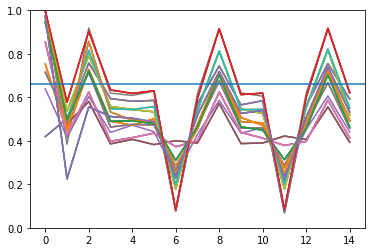

In [420]:
plt.plot(score.mean((1)).T)
plt.ylim(0,1)
plt.axhline(.66)

Text(0.5,0,'OG')

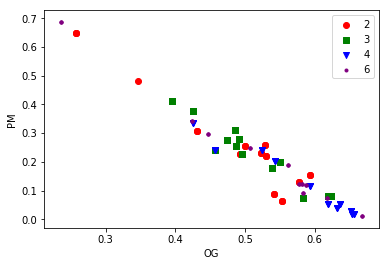

In [400]:
ax = plt.gca()
mL = ['o',',','v','.']
cL = ['r','g','b','purple']
trL = [2,3,4,6]
wL = [1,2,3]
for i,g in enumerate(trL):
  fpath = 'purewm_20*-pmtrials_%i-*'%g
#   fpath = 'purewm_20*-pmweight_%i-*'%g
  score = load_score(fpath)
  ogacc = score[:,:,og_trials].mean((1,2))
  pmacc = score[:,:,pm_trials].mean((1,2))
  ax.scatter(ogacc,pmacc,c=cL[i],marker=mL[i],label=g)

plt.legend()
ax.set_ylabel('PM')
ax.set_xlabel('OG')
# ax.set_xlim(0,1)
# ax.set_ylim(0,1)

# LSTM(10)

In [24]:
og_trials = [4,5]
pm_trials = [6,11]
score_em = load_score('wmem')
score_wm = load_score('purewm')
score_em.shape

model_data/wmem_10-pmtrials_3-seqlen_25-seed_1.npy
model_data/wmem_10-pmtrials_3-seqlen_25-seed_0.npy
model_data/wmem_10-pmtrials_3-seqlen_25-seed_2.npy
model_data/wmem_10-pmtrials_3-seqlen_25-seed_3.npy
model_data/purewm_10-pmtrials_3-seqlen_25-seed_100.npy
model_data/purewm_10-pmtrials_3-seqlen_25-seed_101.npy
model_data/purewm_10-pmtrials_3-seqlen_25-seed_103.npy
model_data/purewm_10-pmtrials_3-seqlen_25-seed_102.npy
model_data/purewm_10-pmtrials_3-seqlen_25-seed_104.npy


(4, 1500, 15)

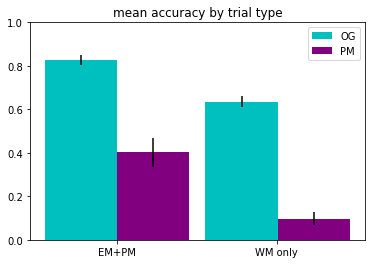

In [166]:
ax = plt.gca()

cL = ['c','purple']
archL = ['EM+WM','WM only']

labL = [['OG','PM'],['_nolegend_','_nolegend_']]
for idx,score in enumerate([score_em,score_wm]):
  for idx2,trial_type in enumerate([og_trials,pm_trials]):
    trial_score = score[:,:,trial_type]
    M = trial_score.mean()
    S = trial_score.mean((1,2)).std(0)/np.sqrt(len(score))
    ax.bar(idx+idx2*.45,M,yerr=S,width=.45,color=cL[idx2],label=labL[idx][idx2])
    
ax.set_ylim(0,1)
ax.set_xticks(np.arange(.22,1.26,1))
ax.set_xticklabels(['EM+PM','WM only'])
plt.legend()
ax.set_title('mean accuracy by trial type')
# plt.savefig('figures/meanacc-by-trialtype')

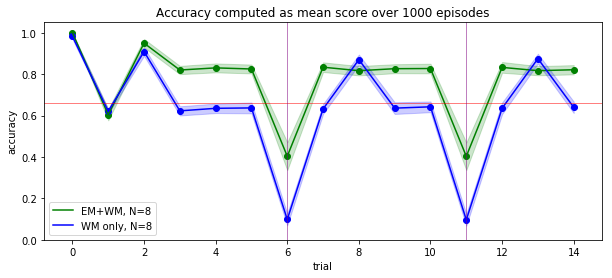

In [168]:
plt.figure(figsize=(10,4))
ax = plt.gca()
cL = ['g','b']
archL = ['EM+WM','WM only']
for idx,score in enumerate([score_em,score_wm]):
  acc = score.mean(1)
  M = acc.mean(0)
  S = acc.std(0)/np.sqrt(len(acc))
  ax.plot(M,c=cL[idx],label="%s, N=%i"%(archL[idx],len(acc)))
  ax.scatter(range(len(M)),M,c=cL[idx])
  ax.fill_between(range(len(M)),M-S,M+S,alpha=.2,color=cL[idx])

plt.legend()
ax.set_ylim(0,1.05)
ax.axhline(.66,c='r',lw=.5)
ax.axvline(6,c='purple',lw=.5)
ax.axvline(11,c='purple',lw=.5)
ax.set_xlabel('trial')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy computed as mean score over 1000 episodes')

# plt.savefig('figures/acc-per-trial')

### individual differences

Text(0.5,0,'trial')

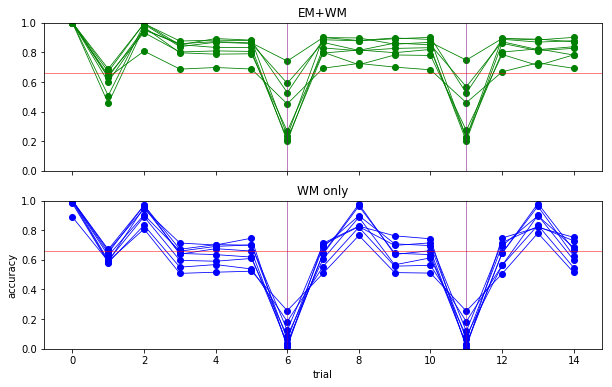

In [31]:
fig,axarr = plt.subplots(2,1,figsize=(10,6),sharex=True)
ax = axarr[0]
cL = ['g','b']
archL = ['EM+WM','WM only']
for idx,score in enumerate([score_em,score_wm]):
  ax = axarr[idx]
  acc = score.mean(1)
  ax.plot(acc.T,c=cL[idx],lw=.8)
  for a in acc:
    ax.scatter(np.arange(len(a)),a,c=cL[idx])
  ax.set_ylim(0,1)
  ax.axhline(.66,c='r',lw=.5)
  ax.axvline(6,c='purple',lw=.5)
  ax.axvline(11,c='purple',lw=.5)
  ax.set_title(archL[idx])
ax.set_ylabel('accuracy')
ax.set_xlabel('trial')

# plt.savefig('figures/acc-per-subject')

* monitoring strategy: higher performance in PM task leads to lower performance in OG task

In [52]:
# load purewm(10) trained on a variety of environments
score_wm = load_score('purewm_10*')
score_wm.shape

(30, 1500, 15)

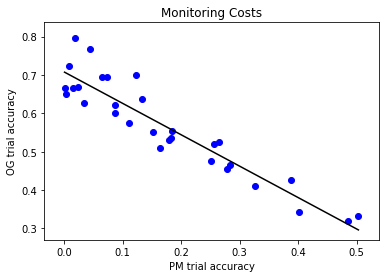

In [54]:
ax = plt.gca()
#scatteer
PMacc = score_wm[:,:,pm_trials].mean((1,2))
OGacc = score_wm[:,:,og_trials].mean((1,2))
ax.scatter(PMacc,OGacc,c='b')
# LINE BEST FIT
x=PMacc
y=OGacc
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),c='black')

# lab
ax.set_title('Monitoring Costs')
ax.set_xlabel('PM trial accuracy')
ax.set_ylabel('OG trial accuracy')
# plt.savefig('figures/individual_difference_in_monitoring_costs')

### comparing different capacities

In [62]:
accD = {}
for stsize in [2,5,10,20]:
  accD[stsize] = load_score('purewm_%i*'%stsize).mean(1)

(3, 15)

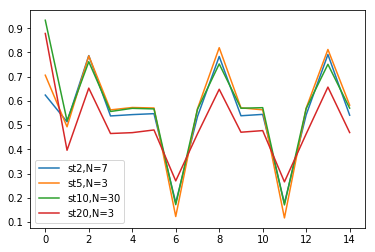

In [65]:
for stsize,acc in accD.items():
  M = acc.mean(0)
  S = acc.std(0)/np.sqrt(len(acc))
  plt.plot(M,label='st%i,N=%i'%(stsize,len(acc)))
  
plt.legend()
acc.shape

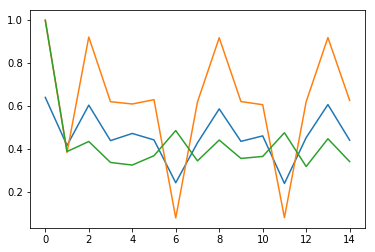

In [74]:
plt.plot(accD[20].T)

# train and eval script

In [391]:
## task
nback=2
num_og_tokens=3
num_pm_trials = 3
seqlen = 25
## network
edim_og = 5
edim_pm = 0
stsize = 10
batch=1
outdim=3
arch = 'wmem'

In [394]:
# model and task
if arch=='purewm':
  net = Net(edim,stsize,outdim)
elif arch=='wmem':
  net = Net_wmem(edim,stsize,outdim)
  
task = NBackPMTask(nback,num_og_tokens,num_pm_trials,edim_og,edim_pm,focal=True)

# specify loss and optimizer
lossop = tr.nn.CrossEntropyLoss(weight=tr.Tensor([1,1]))
optiop = tr.optim.Adam(net.parameters(), lr=0.005)

### train

In [395]:
thresh = .99
nepochs = 1
L = -np.ones([nepochs])
A = -np.ones([nepochs])
E = -np.ones([nepochs])

acc = 0
nembeds = 0
for ep in range(nepochs):
  if ep%(nepochs/5)==0:
    print(ep/nepochs)
  optiop.zero_grad() 
  # randomize emat
  if acc>thresh:
    task.sample_emat()
    nembeds+=1
  # generate data
  x_seq,y_seq = task.gen_seq(seqlen)
  x_embeds,ytarget = task.embed_seq(x_seq,y_seq)
  print(x_embeds.shape,ytarget.shape)
  # forward prop
  yhat = net(x_embeds)
  # collect loss through time
  loss,acc = 0,0
  for yh,yt in zip(yhat,ytarget):
    loss += lossop(yh,yt)
    acc += yt==tr.argmax(tr.softmax(yh,1))
  acc = acc.numpy()/seqlen
  # bp and update
  loss.backward()
  optiop.step()
  epoch_loss = loss.item()
  L[ep] = epoch_loss
  A[ep] = acc
  E[ep] = nembeds

0.0
torch.Size([25, 1, 5]) torch.Size([25, 1])


RuntimeError: weight tensor should be defined either for all 3 classes or no classes but got weight tensor of shape: [2] at /Users/administrator/nightlies/pytorch-1.0.0/wheel_build_dirs/conda_3.6/conda/conda-bld/pytorch_1544137972173/work/aten/src/THNN/generic/ClassNLLCriterion.c:29

### eval

In [88]:
seqlen = 15
neps = 1500
score = -np.ones([neps,seqlen])

for ep in range(neps):
  # embedding matrix
  Emat = tr.FloatTensor(num_og_tokens+1,edim).uniform_(0,1)
  # generate data
  x_int,ytarget = task.gen_seq(seqlen,pm_trial_position=[5,9])
  ytarget = tr.LongTensor(ytarget).unsqueeze(1)
  # embed inputs
  x_embeds = Emat[x_int]
  x_embeds = x_embeds.unsqueeze(1)
  # forward prop
  yhat = net(x_embeds)
  ep_score = (ytarget == tr.softmax(yhat,-1).argmax(-1)).float().squeeze()
  score[ep] = ep_score 



[autoreload of PMmodel failed: Traceback (most recent call last):
  File "/Users/abeukers/anaconda/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "/Users/abeukers/wd/pm/PMmodel.py", line 47
    self.emat =
               ^
SyntaxError: invalid syntax
]


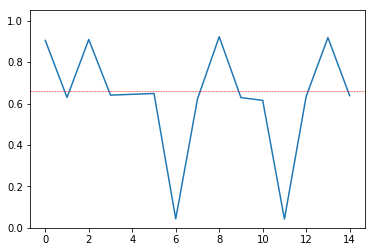

In [89]:
plt.plot(score.mean(0))
plt.ylim(0,1.05)
plt.axhline(.66,c='r',lw=.5,ls='--')

array([[0.66037688, 0.99949   ],
       [0.05628228, 0.15712528]])